In [1]:
import os
import random
import pandas as pd
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from progressbar import progressbar

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6



In [3]:
shuffled_folder = 'dataset/shuffled/'
shuffled_files = [shuffled_folder + file for file in os.listdir(shuffled_folder)]
random.shuffle(shuffled_files)

In [4]:
num_files = len(shuffled_files)
training_cut = round(0.4 * num_files)
cross_cut = round(0.7 * num_files)

In [5]:
training_files = shuffled_files[:training_cut]
cross_validation_files = shuffled_files[training_cut:cross_cut]
test_files = shuffled_files[cross_cut:]

In [6]:
def count_rows_in_files(files):
    res = 0
    for file in files:
        df = pd.read_parquet(file)
        res += len(df)
    
    return res

In [8]:
training_rows = count_rows_in_files(training_files)
cross_val_rows = count_rows_in_files(cross_validation_files)
test_rows = count_rows_in_files(test_files)

In [9]:
training_rows, cross_val_rows, test_rows

(126960106, 95696597, 102653243)

In [10]:
total_rows = training_rows + cross_val_rows + test_rows

In [11]:
total_rows

325309946

In [12]:
print(f'training {100 * training_rows / total_rows:.2f}%')
print(f'cross {100 * cross_val_rows / total_rows:.2f}%')
print(f'test {100 * test_rows / total_rows:.2f}%')

training 39.03%
cross 29.42%
test 31.56%


### Base DFs for cross validation

starting with only one df (10 million rows), should be enough to have an idea of the performance of different models, I will escalate later

In [7]:
def get_train_test_dfs(file):
    df = pd.read_parquet(file)
    df = df.fillna(0)
    X = df[[i for i in df.columns if not i == 'label']]
    y = df[['label']]
    return train_test_split(X, y, test_size=0.3, stratify=y)

In [8]:
X_train, X_test, y_train, y_test = get_train_test_dfs('dataset/shuffled/part_6')

In [9]:
len(X_train)

6587395

In [10]:
len(X_test)

2823170

In [11]:
len(y_train)

6587395

In [12]:
len(y_test)

2823170

In [13]:
def check_distrib(df):
    df = df[['label']]
    ones = len(df[df['label'] == 1])
    return ones / len(df)

just checking the stratify

In [14]:
check_distrib(y_train)

0.739918890547781

In [15]:
check_distrib(y_test)

0.7399189563504854

### Helper functions

In [16]:
def plot_confusion_matrix(y_true, y_pred):
    conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    conf_mat.plot()

In [17]:
def get_results_from_cv(cv):
    return pd.DataFrame(cv.cv_results_).drop(['params'], axis=1).sort_values('mean_test_score', ascending=False)

In [18]:
def show_feature_importances(estimator, columns):
    return pd.DataFrame(data={'importance': estimator.feature_importances_}, index=columns).sort_values('importance', ascending=False).applymap(lambda v: f'{100 * v:.2f}%')

### Starting with a random forest as control

In [107]:
cv = GridSearchCV(RandomForestClassifier(), {
    'n_estimators': [1, 10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 10, 100, None]
}, scoring='f1', n_jobs=16, verbose=3, cv=StratifiedKFold())

In [57]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=16,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 100, None],
                         'n_estimators': [1, 10, 100, 1000]},
             scoring='f1', verbose=3)

In [75]:
get_results_from_cv(cv)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,43.867459,3.240281,1.639186,0.119938,entropy,10,100,0.884714,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
5,5.215665,0.267522,0.339433,0.082126,gini,10,10,0.884715,0.884930,0.884720,0.884480,0.885018,0.884773,0.000188,2
6,40.408750,1.648401,1.468573,0.164781,gini,10,100,0.884715,0.884930,0.884720,0.884480,0.885018,0.884773,0.000188,2
23,382.526772,4.300434,12.294869,0.172509,entropy,10,1000,0.884709,0.884934,0.884720,0.884480,0.885018,0.884772,0.000189,4
30,38.990859,1.193481,1.422491,0.028443,entropy,None,100,0.884709,0.884934,0.884720,0.884480,0.885018,0.884772,0.000189,4
7,390.429645,13.011543,12.899477,0.642416,gini,10,1000,0.884709,0.884934,0.884720,0.884480,0.885018,0.884772,0.000189,4
10,42.922745,1.921866,1.765949,0.270186,gini,100,100,0.884709,0.884930,0.884720,0.884480,0.885018,0.884771,0.000189,7
11,399.425347,12.275884,12.649745,0.378638,gini,100,1000,0.884709,0.884930,0.884720,0.884480,0.885018,0.884771,0.000189,7
13,5.767909,0.608522,0.350185,0.044068,gini,None,10,0.884705,0.884930,0.884720,0.884480,0.885018,0.884771,0.000189,9
26,39.847090,1.374815,1.560764,0.130976,entropy,100,100,0.884705,0.884930,0.884720,0.884480,0.885018,0.884771,0.000189,9


In [63]:
cv.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}

In [58]:
best = cv.best_estimator_
y_pred = best.predict(X_test)

RandomForestClassifier(criterion='entropy', max_depth=10)

---

### Training best params on 10 M rows to check

In [27]:
model_rf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=100)

In [28]:
model_rf.fit(X_train, y_train)

<ipython-input-28-2d0ea5064a37>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=10)

In [29]:
y_pred = model_rf.predict(X_test)

F1 = 0.9082205822726743
Accuracy = 0.8504656113517783
Precision = 0.8319149376816639
Recall = 0.9999377667949468 



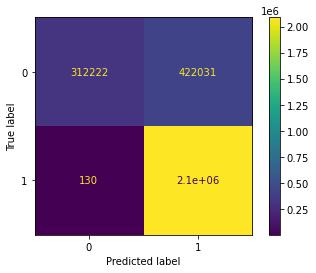

In [30]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Accuracy =', accuracy_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [31]:
show_feature_importances(model_rf, X_train.columns).head(10)

,importance
duration,44.82%
conn_state_s0,25.29%
conn_state_rstos0,18.08%
orig_bytes,4.37%
conn_state_oth,2.20%
orig_ip_bytes,1.68%
orig_pkts,1.11%
proto_tcp,0.62%
resp_ip_bytes,0.46%
proto_icmp,0.38%


---

F1 = 0.8850851148492945 



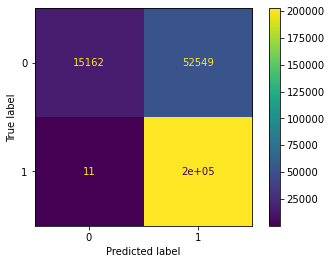

In [111]:
print(f'F1 =', f1_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [95]:
show_feature_importances(best, X_train.columns).head(10)

,importance
duration,67.39%
conn_state_s0,10.29%
resp_pkts,7.37%
resp_ip_bytes,4.10%
proto_tcp,4.04%
proto_udp,2.61%
conn_state_sf,1.12%
proto_icmp,0.64%
service_dns,0.57%
conn_state_s3,0.56%


In [101]:
aux = pd.concat([X_train, y_train], axis=1)[['duration', 'conn_state_s0', 'resp_pkts', 'resp_ip_bytes', 'conn_state_sf', 'label']]
aux

,duration,conn_state_s0,resp_pkts,resp_ip_bytes,conn_state_sf,label
4060710,3.327853e-05,1,0.0,0.0,0,0
5516864,0.000000e+00,1,0.0,0.0,0,1
1535360,0.000000e+00,1,0.0,0.0,0,1
8524678,0.000000e+00,1,0.0,0.0,0,1
5121523,0.000000e+00,1,0.0,0.0,0,1
...,...,...,...,...,...,...
1978437,2.744424e-09,1,0.0,0.0,0,1
2444885,0.000000e+00,1,0.0,0.0,0,1
2354317,0.000000e+00,1,0.0,0.0,0,1
3946927,4.288163e-11,1,0.0,0.0,0,1


In [102]:
aux.corr()

,duration,conn_state_s0,resp_pkts,resp_ip_bytes,conn_state_sf,label
duration,1.000000,-0.057302,0.965244,0.268350,0.000629,-0.010054
conn_state_s0,-0.057302,1.000000,-0.190571,-0.127418,-0.679276,0.035680
resp_pkts,0.965244,-0.190571,1.000000,0.449830,0.081531,-0.005664
resp_ip_bytes,0.268350,-0.127418,0.449830,1.000000,0.129847,-0.000762
conn_state_sf,0.000629,-0.679276,0.081531,0.129847,1.000000,-0.023472
label,-0.010054,0.035680,-0.005664,-0.000762,-0.023472,1.000000


---

### Gradient Boosting

In [117]:
cv = GridSearchCV(GradientBoostingClassifier(verbose=1), {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [1, 10, 100],
    'criterion': ['friedman_mse', 'mse']
}, scoring='f1', n_jobs=16, verbose=3, cv=StratifiedKFold())

In [118]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           1.1226           20.39s
         2           1.1193           19.89s
         3           1.1160           19.75s
         4           1.1129           19.50s
         5           1.1099           19.24s
         6           1.1070           19.01s
         7           1.1042           18.81s
         8           1.1014           18.63s
         9           1.0988           18.40s
        10           1.0963           18.21s
        20           1.0744           16.13s
        30           1.0576           14.10s
        40           1.0441           12.05s
        50           1.0332           10.03s
        60           1.0240            8.02s
        70           1.0164            6.01s
        80           1.0098            4.01s
        90           1.0043            2.00s
       100           0.9994            0.00s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(verbose=1), n_jobs=16,
             param_grid={'criterion': ['friedman_mse', 'mse'],
                         'learning_rate': [0.001, 0.01, 0.1, 0.5],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [1, 10, 100]},
             scoring='f1', verbose=3)

In [119]:
get_results_from_cv(cv)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,12.546955,0.304843,0.356636,0.009651,friedman_mse,0.1,exponential,10,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
46,12.802463,0.192085,0.392200,0.018581,mse,0.5,exponential,10,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
32,105.179619,1.459828,1.114755,0.117892,mse,0.01,deviance,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
35,111.243918,1.908517,1.101338,0.035882,mse,0.01,exponential,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
22,12.760115,0.309715,0.396205,0.025951,friedman_mse,0.5,exponential,10,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
41,107.572352,1.528137,1.229486,0.135867,mse,0.1,exponential,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
8,106.274217,2.040451,1.095689,0.078076,friedman_mse,0.01,deviance,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
40,12.848133,0.417106,0.375912,0.020172,mse,0.1,exponential,10,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
11,111.509541,2.791832,1.189197,0.086453,friedman_mse,0.01,exponential,100,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1
18,2.417484,0.099380,0.301200,0.015740,friedman_mse,0.5,deviance,1,0.884715,0.884934,0.884720,0.884480,0.885018,0.884773,0.000189,1


In [120]:
cv.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.01,
 'loss': 'deviance',
 'n_estimators': 100}

---

### Training best params on 10 M rows

In [32]:
model_gb = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.01, loss='deviance', n_estimators=100)

In [33]:
model_gb.fit(X_train, y_train)

C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingClassifier(learning_rate=0.01)

In [34]:
y_pred = model_gb.predict(X_test)

F1 = 0.9082599510506921
Accuracy = 0.850565499066652
Precision = 0.8321165963666037
Recall = 0.9997419715575104 



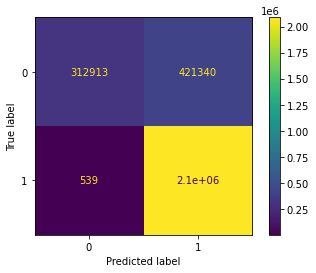

In [35]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Accuracy =', accuracy_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [36]:
show_feature_importances(model_gb, X_train.columns).head(10)

,importance
duration,89.62%
conn_state_s0,10.04%
proto_tcp,0.19%
conn_state_rej,0.05%
resp_ip_bytes,0.05%
proto_udp,0.03%
resp_pkts,0.02%
conn_state_sf,0.00%
conn_state_rstos0,0.00%
conn_state_rsto,0.00%


---

In [121]:
best = cv.best_estimator_
y_pred = best.predict(X_test)

F1 = 0.8850831797421418 



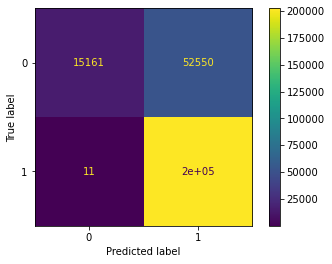

In [122]:
print(f'F1 =', f1_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [123]:
show_feature_importances(best, X_train.columns).head(10)

,importance
duration,99.09%
conn_state_s0,0.72%
proto_tcp,0.07%
proto_udp,0.06%
resp_pkts,0.05%
conn_state_rsto,0.00%
orig_bytes,0.00%
orig_ip_bytes,0.00%
conn_state_oth,0.00%
orig_pkts,0.00%


---

### XG Boost

In [19]:
train = xgb.DMatrix(X_train, label=y_train)

#### params:

- eta -> range: [0,1] (default=0.3)
- gamma -> range: [0,∞] (default=0)
- max_depth -> range: [0,∞] (default=6)
- tree_method -> 'gpu_hist'

In [27]:
%%time
model = xgb.train({'eta': 0.3, 'gamma': 0, 'max_depth': 6, 'tree_method': 'gpu_hist'}, train)      # start with default params

Wall time: 858 ms


In [28]:
y_pred = model.predict(xgb.DMatrix(X_test, label=y_test))

In [29]:
y_pred = y_pred.round()

F1 = 0.9751197166249423
Accuracy = 0.9622449232600233
Precision = 0.9515228516580583
Recall = 0.9999167032486211 



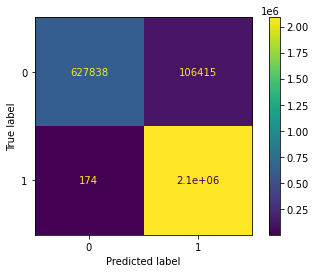

In [30]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Accuracy =', accuracy_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

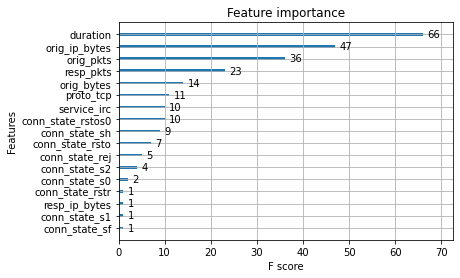

In [31]:
xgb.plot_importance(model)

In [20]:
def xgb_grid_search(params_list):
    res_df = pd.DataFrame()
    for params in progressbar(params_list):
        model = xgb.train(params, train)
        y_pred = model.predict(xgb.DMatrix(X_test, label=y_test)).round()
        res_df = res_df.append(pd.DataFrame(data={
            **{key: [val] for key, val in params.items()},
            **{
                'f1': f1_score(y_test, y_pred),
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred)
            }
        }))
    display(res_df.sort_values('precision', ascending=False))

In [45]:
xgb_grid_search(params_list = [
    {'eta': 0.5, 'gamma': 0, 'max_depth': 6, 'tree_method': 'gpu_hist'},          # gpu_hist -> run with gpu
    {'eta': 0.3, 'gamma': 0, 'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'eta': 0.1, 'gamma': 0, 'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'eta': 0.01, 'gamma': 0, 'max_depth': 6, 'tree_method': 'gpu_hist'}
])

100% (4 of 4) |##########################| Elapsed Time: 0:00:19 Time:  0:00:19


,eta,gamma,max_depth,tree_method,f1,accuracy,precision,recall
0,0.30,0,6,gpu_hist,0.975120,0.962245,0.951523,0.999917
0,0.50,0,6,gpu_hist,0.975120,0.962245,0.951522,0.999917
0,0.10,0,6,gpu_hist,0.974549,0.961355,0.950425,0.999929
0,0.01,0,6,gpu_hist,0.974547,0.961353,0.950424,0.999928


In [46]:
xgb_grid_search(params_list = [
    {'gamma': 0, 'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'gamma': 0.1, 'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'gamma': 1, 'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'gamma': 10, 'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'gamma': 100, 'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'gamma': 1000, 'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'gamma': 1_000_000, 'max_depth': 6, 'tree_method': 'gpu_hist'}
])

100% (7 of 7) |##########################| Elapsed Time: 0:00:33 Time:  0:00:33


,gamma,max_depth,tree_method,f1,accuracy,precision,recall
0,0.0,6,gpu_hist,0.975120,0.962245,0.951523,0.999917
0,0.1,6,gpu_hist,0.975120,0.962245,0.951523,0.999917
0,1.0,6,gpu_hist,0.975119,0.962245,0.951523,0.999916
0,10.0,6,gpu_hist,0.975117,0.962240,0.951516,0.999918
0,100.0,6,gpu_hist,0.974518,0.961306,0.950345,0.999953
0,1000.0,6,gpu_hist,0.974467,0.961227,0.950248,0.999953
0,1000000.0,6,gpu_hist,0.850521,0.739919,0.739919,1.000000


In [22]:
xgb_grid_search(params_list = [
    {'max_depth': 1, 'tree_method': 'gpu_hist'},
    {'max_depth': 6, 'tree_method': 'gpu_hist'},
    {'max_depth': 10, 'tree_method': 'gpu_hist'},
    {'max_depth': 20, 'tree_method': 'gpu_hist'}      # error when > 20 (memory)
])

100% (4 of 4) |##########################| Elapsed Time: 0:00:19 Time:  0:00:19


,max_depth,tree_method,f1,accuracy,precision,recall
0,6,gpu_hist,0.975136,0.962270,0.951554,0.999917
0,10,gpu_hist,0.975143,0.962280,0.951548,0.999937
0,20,gpu_hist,0.975143,0.962280,0.951548,0.999937
0,1,gpu_hist,0.904465,0.844721,0.830139,0.993409


In [23]:
best_params = {'eta': 0.3, 'gamma': 0, 'max_depth': 6, 'tree_method': 'gpu_hist'}           # default params

In [24]:
model_xgb = xgb.train(best_params, train)

In [44]:
y_pred = model_xgb.predict(xgb.DMatrix(X_test)).round()

F1 = 0.9751358775575373
Accuracy = 0.9622700722946191
Precision = 0.9515536286261091
Recall = 0.9999167032486211 



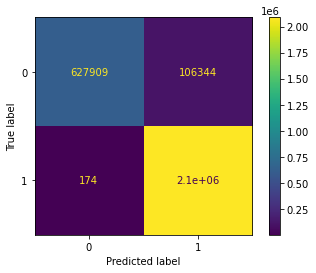

In [45]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Accuracy =', accuracy_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

---

In [71]:
models = {'rf': model_rf, 'gb': model_gb, 'xgb': model_xgb}
pred_funcs = {
    'rf': model_rf.predict,
    'gb': model_gb.predict,
    'xgb': lambda X_test: model_xgb.predict(xgb.DMatrix(X_test)).round()
}
res = {model_name: {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0} for model_name in models}
total_obs = 0

In [72]:
for file in progressbar(shuffled_files):
    print(f'running {file}')
    df = pd.read_parquet(file)
    df = df.fillna(0)
    X = df[[i for i in df.columns if not i == 'label']]
    y = df[['label']]
    print('distrib:', check_distrib(y))
    total_obs += len(y)
    for model_name, model in models.items():
        y_pred = pred_funcs[model_name](X)
        aux = y.reset_index(drop=True).join(pd.DataFrame(data={'predicted': y_pred}).applymap(int))
        res[model_name]['tp'] += len(aux[(aux['label'] == 1) & (aux['predicted'] == 1)])
        res[model_name]['tn'] += len(aux[(aux['label'] == 0) & (aux['predicted'] == 0)])
        res[model_name]['fp'] += len(aux[(aux['label'] == 0) & (aux['predicted'] == 1)])
        res[model_name]['fn'] += len(aux[(aux['label'] == 1) & (aux['predicted'] == 0)])
    
    print(f'total_obs={total_obs}')
    print(res)

N/A% (0 of 35) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

running dataset/shuffled/part_31
distrib: 0.8846232078959143


  2% (1 of 35) |                         | Elapsed Time: 0:00:46 ETA:   0:26:07

total_obs=8023390
{'rf': {'tp': 6595472, 'tn': 4852, 'fp': 920861, 'fn': 502205}, 'gb': {'tp': 6596952, 'tn': 4704, 'fp': 921009, 'fn': 500725}, 'xgb': {'tp': 6575987, 'tn': 4887, 'fp': 920826, 'fn': 521690}}
running dataset/shuffled/part_16
distrib: 0.9947733052266948


  5% (2 of 35) |#                        | Elapsed Time: 0:01:43 ETA:   0:31:30

total_obs=18023400
{'rf': {'tp': 16542975, 'tn': 6461, 'fp': 971519, 'fn': 502445}, 'gb': {'tp': 16544439, 'tn': 6203, 'fp': 971777, 'fn': 500981}, 'xgb': {'tp': 15523904, 'tn': 7081, 'fp': 970899, 'fn': 1521516}}
running dataset/shuffled/part_34
distrib: 0.8256905455599589


  8% (3 of 35) |##                       | Elapsed Time: 0:02:35 ETA:   0:27:47

total_obs=27033812
{'rf': {'tp': 23980309, 'tn': 317466, 'fp': 2231114, 'fn': 504923}, 'gb': {'tp': 23981733, 'tn': 317354, 'fp': 2231226, 'fn': 503499}, 'xgb': {'tp': 22955003, 'tn': 629767, 'fp': 1918813, 'fn': 1530229}}
running dataset/shuffled/part_32
distrib: 0.9045593954406046


 11% (4 of 35) |##                       | Elapsed Time: 0:03:31 ETA:   0:29:07

total_obs=37033822
{'rf': {'tp': 33025202, 'tn': 320521, 'fp': 3182466, 'fn': 505633}, 'gb': {'tp': 33023531, 'tn': 320185, 'fp': 3182802, 'fn': 507304}, 'xgb': {'tp': 31999908, 'tn': 632802, 'fp': 2870185, 'fn': 1530927}}
running dataset/shuffled/part_18
distrib: 0.8954972544261396


 14% (5 of 35) |###                      | Elapsed Time: 0:04:22 ETA:   0:25:15

total_obs=46037040
{'rf': {'tp': 41085665, 'tn': 326682, 'fp': 4117166, 'fn': 507527}, 'gb': {'tp': 41083971, 'tn': 326150, 'fp': 4117698, 'fn': 509221}, 'xgb': {'tp': 40060258, 'tn': 638954, 'fp': 3804894, 'fn': 1532934}}
running dataset/shuffled/part_21
distrib: 0.9661127338872662


 17% (6 of 35) |####                     | Elapsed Time: 0:05:18 ETA:   0:27:07

total_obs=56037050
{'rf': {'tp': 50746188, 'tn': 333039, 'fp': 4449682, 'fn': 508141}, 'gb': {'tp': 50744486, 'tn': 332345, 'fp': 4450376, 'fn': 509843}, 'xgb': {'tp': 49720692, 'tn': 645244, 'fp': 4137477, 'fn': 1533637}}
running dataset/shuffled/part_29
distrib: 0.9312561678807592


 20% (7 of 35) |#####                    | Elapsed Time: 0:06:09 ETA:   0:23:35

total_obs=65040345
{'rf': {'tp': 59129873, 'tn': 339996, 'fp': 5061646, 'fn': 508830}, 'gb': {'tp': 59128145, 'tn': 339171, 'fp': 5062471, 'fn': 510558}, 'xgb': {'tp': 58104342, 'tn': 652127, 'fp': 4749515, 'fn': 1534361}}
running dataset/shuffled/part_28
distrib: 0.9591060408939591


 22% (8 of 35) |#####                    | Elapsed Time: 0:07:05 ETA:   0:25:20

total_obs=75040355
{'rf': {'tp': 68720089, 'tn': 343145, 'fp': 5467437, 'fn': 509684}, 'gb': {'tp': 68718305, 'tn': 342089, 'fp': 5468493, 'fn': 511468}, 'xgb': {'tp': 67694318, 'tn': 655269, 'fp': 5155313, 'fn': 1535455}}
running dataset/shuffled/part_30
distrib: 0.8999579000421


 25% (9 of 35) |######                   | Elapsed Time: 0:08:02 ETA:   0:24:56

total_obs=85040365
{'rf': {'tp': 77155905, 'tn': 345999, 'fp': 6465005, 'fn': 1073456}, 'gb': {'tp': 77153985, 'tn': 344837, 'fp': 6466167, 'fn': 1075376}, 'xgb': {'tp': 76123858, 'tn': 658117, 'fp': 6152887, 'fn': 2105503}}
running dataset/shuffled/part_33
distrib: 0.8191319751771953


 28% (10 of 35) |######                  | Elapsed Time: 0:08:49 ETA:   0:19:25

total_obs=93057509
{'rf': {'tp': 83720697, 'tn': 1067605, 'fp': 7193444, 'fn': 1075763}, 'gb': {'tp': 83718823, 'tn': 1066324, 'fp': 7194725, 'fn': 1077637}, 'xgb': {'tp': 82687916, 'tn': 2107948, 'fp': 6153101, 'fn': 2108544}}
running dataset/shuffled/part_9
distrib: 0.872955427044573


 31% (11 of 35) |#######                 | Elapsed Time: 0:09:45 ETA:   0:22:30

total_obs=103057519
{'rf': {'tp': 92449783, 'tn': 1069051, 'fp': 8462445, 'fn': 1076240}, 'gb': {'tp': 92447830, 'tn': 1067656, 'fp': 8463840, 'fn': 1078193}, 'xgb': {'tp': 91416822, 'tn': 2109381, 'fp': 7422115, 'fn': 2109201}}
running dataset/shuffled/part_8
distrib: 0.7493422963239781


 34% (12 of 35) |########                | Elapsed Time: 0:10:36 ETA:   0:19:36

total_obs=112061954
{'rf': {'tp': 99196780, 'tn': 1570083, 'fp': 10218444, 'fn': 1076647}, 'gb': {'tp': 99191732, 'tn': 1569160, 'fp': 10219367, 'fn': 1081695}, 'xgb': {'tp': 98163777, 'tn': 3114185, 'fp': 8674342, 'fn': 2109650}}
running dataset/shuffled/part_23
distrib: 0.8748351251648748


 37% (13 of 35) |########                | Elapsed Time: 0:11:33 ETA:   0:20:32

total_obs=122061964
{'rf': {'tp': 107944532, 'tn': 1572165, 'fp': 11468012, 'fn': 1077255}, 'gb': {'tp': 107939410, 'tn': 1571016, 'fp': 11469161, 'fn': 1082377}, 'xgb': {'tp': 106911441, 'tn': 3116257, 'fp': 9923920, 'fn': 2110346}}
running dataset/shuffled/part_5
distrib: 0.8668877784334915


 40% (14 of 35) |#########               | Elapsed Time: 0:12:25 ETA:   0:18:31

total_obs=131456308
{'rf': {'tp': 115891287, 'tn': 1573834, 'fp': 12716845, 'fn': 1274342}, 'gb': {'tp': 115886046, 'tn': 1572585, 'fp': 12718094, 'fn': 1279583}, 'xgb': {'tp': 114855421, 'tn': 3117920, 'fp': 11172759, 'fn': 2310208}}
running dataset/shuffled/part_14
distrib: 0.906038093961906


 42% (15 of 35) |##########              | Elapsed Time: 0:13:22 ETA:   0:18:54

total_obs=141456318
{'rf': {'tp': 124453802, 'tn': 1576083, 'fp': 13654216, 'fn': 1772217}, 'gb': {'tp': 124448455, 'tn': 1574761, 'fp': 13655538, 'fn': 1777564}, 'xgb': {'tp': 123412483, 'tn': 3120163, 'fp': 12110136, 'fn': 2813536}}
running dataset/shuffled/part_26
distrib: 0.8839383062838712


 45% (16 of 35) |##########              | Elapsed Time: 0:14:11 ETA:   0:15:29

total_obs=150232771
{'rf': {'tp': 132209972, 'tn': 1577561, 'fp': 14671348, 'fn': 1773890}, 'gb': {'tp': 132204628, 'tn': 1576205, 'fp': 14672704, 'fn': 1779234}, 'xgb': {'tp': 131168062, 'tn': 3121640, 'fp': 13127269, 'fn': 2815800}}
running dataset/shuffled/part_3
distrib: 0.990500971701867


 48% (17 of 35) |###########             | Elapsed Time: 0:15:04 ETA:   0:15:50

total_obs=159687317
{'rf': {'tp': 141571875, 'tn': 1580920, 'fp': 14757798, 'fn': 1776724}, 'gb': {'tp': 141566539, 'tn': 1579406, 'fp': 14759312, 'fn': 1782060}, 'xgb': {'tp': 140528958, 'tn': 3124993, 'fp': 13213725, 'fn': 2819641}}
running dataset/shuffled/part_20
distrib: 0.8796316077207247


 51% (18 of 35) |############            | Elapsed Time: 0:15:56 ETA:   0:14:37

total_obs=168688700
{'rf': {'tp': 149304627, 'tn': 2022188, 'fp': 15400012, 'fn': 1961873}, 'gb': {'tp': 149302945, 'tn': 2020209, 'fp': 15401991, 'fn': 1963555}, 'xgb': {'tp': 147911593, 'tn': 3198662, 'fp': 14223538, 'fn': 3354907}}
running dataset/shuffled/part_11
distrib: 0.9590757409242591


 54% (19 of 35) |#############           | Elapsed Time: 0:16:53 ETA:   0:15:12

total_obs=178688710
{'rf': {'tp': 158893802, 'tn': 2025512, 'fp': 15805931, 'fn': 1963465}, 'gb': {'tp': 158892113, 'tn': 2023302, 'fp': 15808141, 'fn': 1965154}, 'xgb': {'tp': 156501159, 'tn': 3202532, 'fp': 14628911, 'fn': 4356108}}
running dataset/shuffled/part_27
distrib: 0.7337409662590337


 57% (20 of 35) |#############           | Elapsed Time: 0:17:50 ETA:   0:14:21

total_obs=188688720
{'rf': {'tp': 166188199, 'tn': 3067361, 'fp': 17426675, 'fn': 2006485}, 'gb': {'tp': 166186532, 'tn': 3067617, 'fp': 17426419, 'fn': 2008152}, 'xgb': {'tp': 163794703, 'tn': 5250612, 'fp': 15243424, 'fn': 4399981}}
running dataset/shuffled/part_10
distrib: 0.9965342276284956


 60% (21 of 35) |##############          | Elapsed Time: 0:18:42 ETA:   0:12:02

total_obs=197844832
{'rf': {'tp': 175239522, 'tn': 3073998, 'fp': 17451771, 'fn': 2079541}, 'gb': {'tp': 175237771, 'tn': 3073844, 'fp': 17451925, 'fn': 2081292}, 'xgb': {'tp': 172770387, 'tn': 5257198, 'fp': 15268571, 'fn': 4548676}}
running dataset/shuffled/part_6
distrib: 0.7399189102885958


 62% (22 of 35) |###############         | Elapsed Time: 0:19:37 ETA:   0:11:59

total_obs=207255397
{'rf': {'tp': 182202171, 'tn': 4113687, 'fp': 18859592, 'fn': 2079947}, 'gb': {'tp': 182199076, 'tn': 4115923, 'fp': 18857356, 'fn': 2083042}, 'xgb': {'tp': 179732881, 'tn': 7349722, 'fp': 15623557, 'fn': 4549237}}
running dataset/shuffled/part_19
distrib: 0.9594395735707536


 65% (23 of 35) |###############         | Elapsed Time: 0:20:24 ETA:   0:09:24

total_obs=215642439
{'rf': {'tp': 190246349, 'tn': 4124739, 'fp': 19188722, 'fn': 2082629}, 'gb': {'tp': 190243236, 'tn': 4126754, 'fp': 19186707, 'fn': 2085742}, 'xgb': {'tp': 187773389, 'tn': 7357162, 'fp': 15956299, 'fn': 4555589}}
running dataset/shuffled/part_15
distrib: 0.9304872695127305


 68% (24 of 35) |################        | Elapsed Time: 0:21:20 ETA:   0:10:14

total_obs=225642449
{'rf': {'tp': 199549614, 'tn': 4126338, 'fp': 19882251, 'fn': 2084246}, 'gb': {'tp': 199546475, 'tn': 4128268, 'fp': 19880321, 'fn': 2087385}, 'xgb': {'tp': 197075279, 'tn': 7358752, 'fp': 16649837, 'fn': 4558581}}
running dataset/shuffled/part_7
distrib: 0.8667358332641667


 71% (25 of 35) |#################       | Elapsed Time: 0:22:16 ETA:   0:09:24

total_obs=235642459
{'rf': {'tp': 208215052, 'tn': 4626101, 'fp': 20715131, 'fn': 2086175}, 'gb': {'tp': 208211945, 'tn': 4628055, 'fp': 20713177, 'fn': 2089282}, 'xgb': {'tp': 205740512, 'tn': 8361086, 'fp': 16980146, 'fn': 4560715}}
running dataset/shuffled/part_35
distrib: 0.9747475252524748


 74% (26 of 35) |#################       | Elapsed Time: 0:22:28 ETA:   0:01:43

total_obs=237642461
{'rf': {'tp': 210164415, 'tn': 4626701, 'fp': 20765036, 'fn': 2086309}, 'gb': {'tp': 210161294, 'tn': 4628632, 'fp': 20763105, 'fn': 2089430}, 'xgb': {'tp': 207689735, 'tn': 8361683, 'fp': 17030054, 'fn': 4560989}}
running dataset/shuffled/part_4
distrib: 0.9379483620516379


 77% (27 of 35) |##################      | Elapsed Time: 0:23:24 ETA:   0:07:31

total_obs=247642471
{'rf': {'tp': 219541408, 'tn': 4633671, 'fp': 21378583, 'fn': 2088809}, 'gb': {'tp': 219538279, 'tn': 4635403, 'fp': 21376851, 'fn': 2091938}, 'xgb': {'tp': 217066402, 'tn': 8368608, 'fp': 17643646, 'fn': 4563815}}
running dataset/shuffled/part_13
distrib: 0.961571620267786


 80% (28 of 35) |###################     | Elapsed Time: 0:24:16 ETA:   0:06:04

total_obs=256947365
{'rf': {'tp': 228487225, 'tn': 4636012, 'fp': 21733814, 'fn': 2090314}, 'gb': {'tp': 228484072, 'tn': 4637625, 'fp': 21732201, 'fn': 2093467}, 'xgb': {'tp': 226011169, 'tn': 8370941, 'fp': 17998885, 'fn': 4566370}}
running dataset/shuffled/part_25
distrib: 0.9620911379088621


 82% (29 of 35) |###################     | Elapsed Time: 0:25:13 ETA:   0:05:38

total_obs=266947375
{'rf': {'tp': 238106386, 'tn': 4658417, 'fp': 22090498, 'fn': 2092074}, 'gb': {'tp': 238100230, 'tn': 4659918, 'fp': 22088997, 'fn': 2098230}, 'xgb': {'tp': 235630184, 'tn': 8393329, 'fp': 18355586, 'fn': 4568276}}
running dataset/shuffled/part_1
distrib: 0.9908448080635199


 85% (30 of 35) |####################    | Elapsed Time: 0:26:03 ETA:   0:04:12

total_obs=275947514
{'rf': {'tp': 247022714, 'tn': 4665845, 'fp': 22165468, 'fn': 2093487}, 'gb': {'tp': 247010492, 'tn': 4667162, 'fp': 22164151, 'fn': 2105709}, 'xgb': {'tp': 244545731, 'tn': 8400752, 'fp': 18430561, 'fn': 4570470}}
running dataset/shuffled/part_22
distrib: 0.9227950761890626


 88% (31 of 35) |#####################   | Elapsed Time: 0:26:58 ETA:   0:03:38

total_obs=285528548
{'rf': {'tp': 255861759, 'tn': 4669113, 'fp': 22901903, 'fn': 2095773}, 'gb': {'tp': 255849499, 'tn': 4670306, 'fp': 22900710, 'fn': 2108033}, 'xgb': {'tp': 252803733, 'tn': 8404325, 'fp': 19166691, 'fn': 5153799}}
running dataset/shuffled/part_24
distrib: 0.9689065310934689


 91% (32 of 35) |#####################   | Elapsed Time: 0:27:54 ETA:   0:02:48

total_obs=295528558
{'rf': {'tp': 265548490, 'tn': 4674470, 'fp': 23207481, 'fn': 2098117}, 'gb': {'tp': 265536237, 'tn': 4675484, 'fp': 23206467, 'fn': 2110370}, 'xgb': {'tp': 262489803, 'tn': 8409618, 'fp': 19472333, 'fn': 5156804}}
running dataset/shuffled/part_12
distrib: 0.9945575097471029


 94% (33 of 35) |######################  | Elapsed Time: 0:28:50 ETA:   0:01:51

total_obs=305309926
{'rf': {'tp': 275276054, 'tn': 4677045, 'fp': 23258141, 'fn': 2098686}, 'gb': {'tp': 275263790, 'tn': 4677850, 'fp': 23257336, 'fn': 2110950}, 'xgb': {'tp': 271217771, 'tn': 8412683, 'fp': 19522503, 'fn': 6156969}}
running dataset/shuffled/part_17
distrib: 0.8093635906364094


 97% (34 of 35) |####################### | Elapsed Time: 0:29:45 ETA:   0:00:55

total_obs=315309936
{'rf': {'tp': 283369095, 'tn': 4678657, 'fp': 25162895, 'fn': 2099289}, 'gb': {'tp': 283356736, 'tn': 4679374, 'fp': 25162178, 'fn': 2111648}, 'xgb': {'tp': 279310643, 'tn': 8414285, 'fp': 21427267, 'fn': 6157741}}
running dataset/shuffled/part_2
distrib: 0.8980862019137981


100% (35 of 35) |########################| Elapsed Time: 0:30:43 Time:  0:30:43


total_obs=325309946
{'rf': {'tp': 292349629, 'tn': 4731923, 'fp': 26128768, 'fn': 2099626}, 'gb': {'tp': 292337226, 'tn': 4732509, 'fp': 26128182, 'fn': 2112029}, 'xgb': {'tp': 288291127, 'tn': 8519736, 'fp': 22340955, 'fn': 6158128}}


In [73]:
res

{'rf': {'tp': 292349629, 'tn': 4731923, 'fp': 26128768, 'fn': 2099626},
 'gb': {'tp': 292337226, 'tn': 4732509, 'fp': 26128182, 'fn': 2112029},
 'xgb': {'tp': 288291127, 'tn': 8519736, 'fp': 22340955, 'fn': 6158128}}

In [74]:
total_obs

325309946

In [75]:
for model_name, model_res in res.items():
    total_res = sum([value for key, value in model_res.items()])
    assert total_obs == total_res, f'Error in {model_name}'

In [76]:
for model_name, model_res in res.items():
    res[model_name]['accuracy'] = (res[model_name]['tp'] + res[model_name]['tn']) / total_obs
    res[model_name]['precision'] = res[model_name]['tp'] / (res[model_name]['tp'] + res[model_name]['fp'])
    res[model_name]['recall'] = res[model_name]['tp'] / (res[model_name]['tp'] + res[model_name]['fn'])
    res[model_name]['f1'] = (2 * res[model_name]['precision'] * res[model_name]['recall']) / (res[model_name]['precision'] + res[model_name]['recall'])

In [80]:
pd.DataFrame(res).T[['accuracy', 'precision', 'recall', 'f1']]

,accuracy,precision,recall,f1
rf,0.913226,0.917957,0.992869,0.953945
gb,0.913190,0.917956,0.992827,0.953925
xgb,0.912394,0.928079,0.979086,0.952900
